# Pre-process ESA Snow CCI data

- Snow Cover Fraction Climate Research Data Package: http://snow-cci.enveo.at/
- summer path: `/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW`

Check missing values, linear interpolation on time, and spatial aggregation

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
# For parallelisation
from dask.distributed import Client
from dask import delayed
from dask import compute
# client = Client(n_workers=4, threads_per_worker=3, memory_limit='4GB')
client = Client(n_workers=4, threads_per_worker=1, memory_limit='4GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:38011 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.00 GB


In [5]:
client.close()

In [3]:
path_snow_CCI = '/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg'
path_AVHRR = path_snow_CCI+'/AVHRR_MERGED/v2.0'
path_MODIS = path_snow_CCI+'/MODIS/v2.0'

In [4]:
%%time
ds = xr.open_mfdataset(path_AVHRR+'/1982/01/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc', parallel=True, chunks={'time': -1, 'lat': 180, 'lon': 360})
ds

CPU times: user 3.32 s, sys: 1.02 s, total: 4.35 s
Wall time: 2min 3s


,Array,Chunk
Bytes,1.73 MB,2.88 kB
Shape,"(30, 3600, 2)","(1, 180, 2)"
Count,1830 Tasks,600 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,3.46 MB,5.76 kB
Shape,"(30, 7200, 2)","(1, 360, 2)"
Count,1830 Tasks,600 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [4]:
%%time
ds = xr.open_mfdataset(path_AVHRR+'/1982/01/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc', parallel=True, chunks={'time': -1, 'lat': 1800, 'lon': 3600})
ds

CPU times: user 1.68 s, sys: 296 ms, total: 1.98 s
Wall time: 14.5 s


,Array,Chunk
Bytes,1.73 MB,28.80 kB
Shape,"(30, 3600, 2)","(1, 1800, 2)"
Count,210 Tasks,60 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,3.46 MB,57.60 kB
Shape,"(30, 7200, 2)","(1, 3600, 2)"
Count,210 Tasks,60 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


# Penser à rajouter la 100% scf sur la glace

In [5]:
scfg = ds.scfg.chunk({'time': -1})

In [6]:
test = scfg.where(scfg <= 100)

In [8]:
test.to_netcdf('/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/1982/198201-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc')

distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [5]:
ds.scfg

,Array,Chunk
Bytes,3.11 GB,259.20 kB
Shape,"(30, 3600, 7200)","(1, 180, 360)"
Count,24030 Tasks,12000 Chunks
Type,float32,numpy.ndarray


In [16]:
%%time
ds.scfg.chunk({'time': -1, 'lat': 1800, 'lon': 3600}).to_netcdf('/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/1982/198201-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc')

CPU times: user 2.55 s, sys: 233 ms, total: 2.79 s
Wall time: 16.4 s


In [8]:
da = ds.scfg.chunk({'time': -1, 'lat': 180, 'lon': 360})
da

,Array,Chunk
Bytes,3.11 GB,7.78 MB
Shape,"(30, 3600, 7200)","(30, 180, 360)"
Count,24430 Tasks,400 Chunks
Type,float32,numpy.ndarray


In [30]:
scf = da.where(da <= 100)

In [10]:
scf.time

<xarray.DataArray 'time' (time: 30)>
array(['1982-01-01T00:00:00.000000000', '1982-01-02T00:00:00.000000000',
       '1982-01-03T00:00:00.000000000', '1982-01-04T00:00:00.000000000',
       '1982-01-05T00:00:00.000000000', '1982-01-06T00:00:00.000000000',
       '1982-01-07T00:00:00.000000000', '1982-01-08T00:00:00.000000000',
       '1982-01-09T00:00:00.000000000', '1982-01-10T00:00:00.000000000',
       '1982-01-11T00:00:00.000000000', '1982-01-12T00:00:00.000000000',
       '1982-01-13T00:00:00.000000000', '1982-01-14T00:00:00.000000000',
       '1982-01-15T00:00:00.000000000', '1982-01-16T00:00:00.000000000',
       '1982-01-17T00:00:00.000000000', '1982-01-18T00:00:00.000000000',
       '1982-01-19T00:00:00.000000000', '1982-01-20T00:00:00.000000000',
       '1982-01-21T00:00:00.000000000', '1982-01-22T00:00:00.000000000',
       '1982-01-23T00:00:00.000000000', '1982-01-24T00:00:00.000000000',
       '1982-01-25T00:00:00.000000000', '1982-01-26T00:00:00.000000000',
       '1982-01-27T00:00:00.000000000', '1982-01-28T00:00:00.000000000',
       '1982-01-29T00:00:00.000000000', '1982-01-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-01-31
Attributes:
    axis:           T
    standard_name:  time
    long_name:      time

## Test global
subset below

In [32]:
scf

<xarray.DataArray 'scfg' (time: 30, lat: 3600, lon: 7200)>
dask.array<where, shape=(30, 3600, 7200), dtype=float32, chunksize=(30, 1800, 3600), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * lat      (lat) float64 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-01-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfg_unc

In [34]:
scf = scf.chunk({'time': -1, 'lat': 1800, 'lon': 1800})

In [36]:
scf.mean('time')

<xarray.DataArray 'scfg' (lat: 3600, lon: 7200)>
dask.array<mean_agg-aggregate, shape=(3600, 7200), dtype=float32, chunksize=(1800, 1800), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * lat      (lat) float64 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97

In [37]:
%%time
clim = scf.mean('time').load()

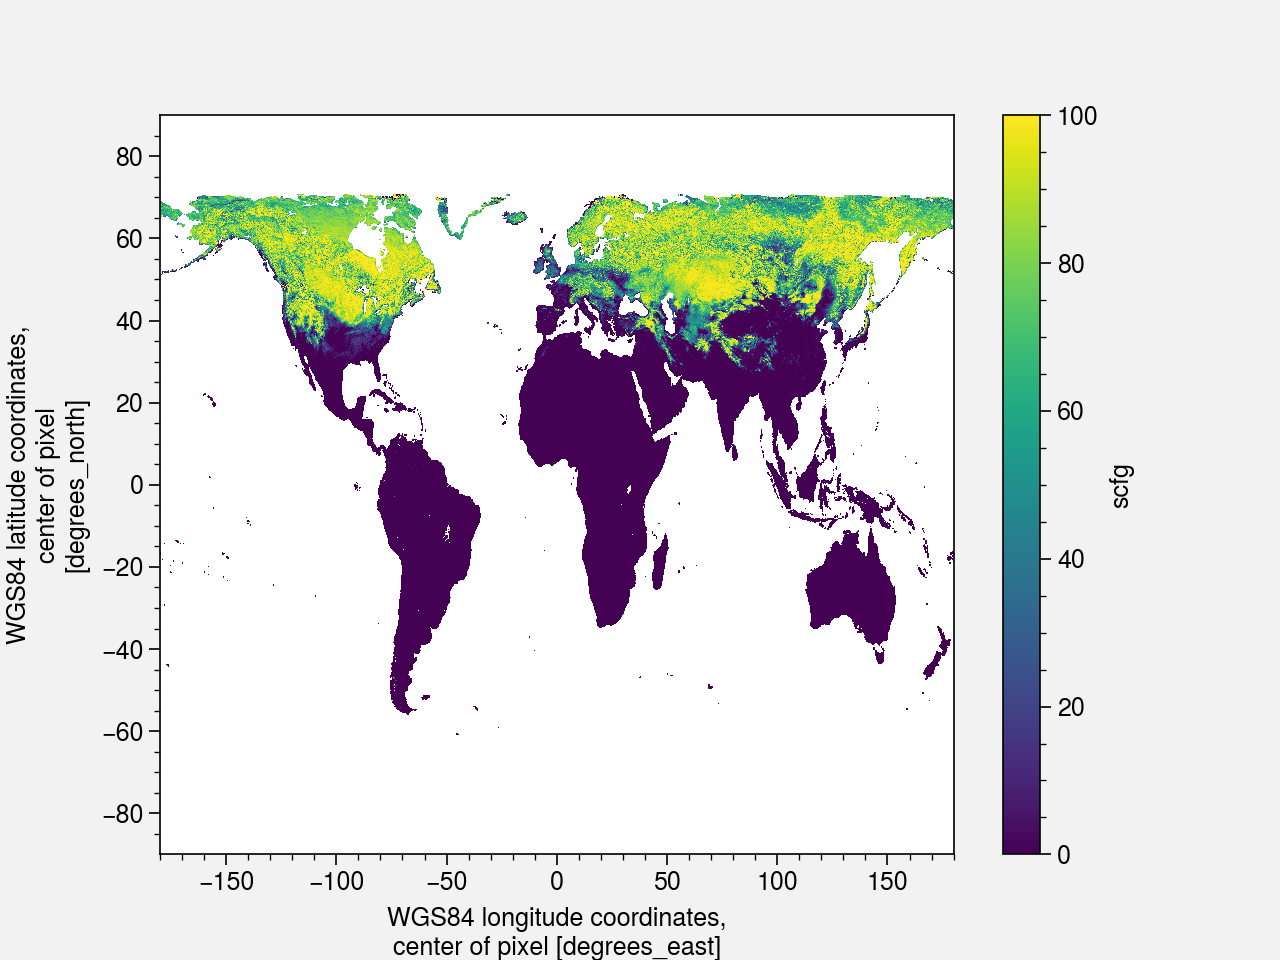

In [38]:
clim.plot()

In [39]:
data_coverage = ((scf.count('time') / scf.time.size)*100).load()

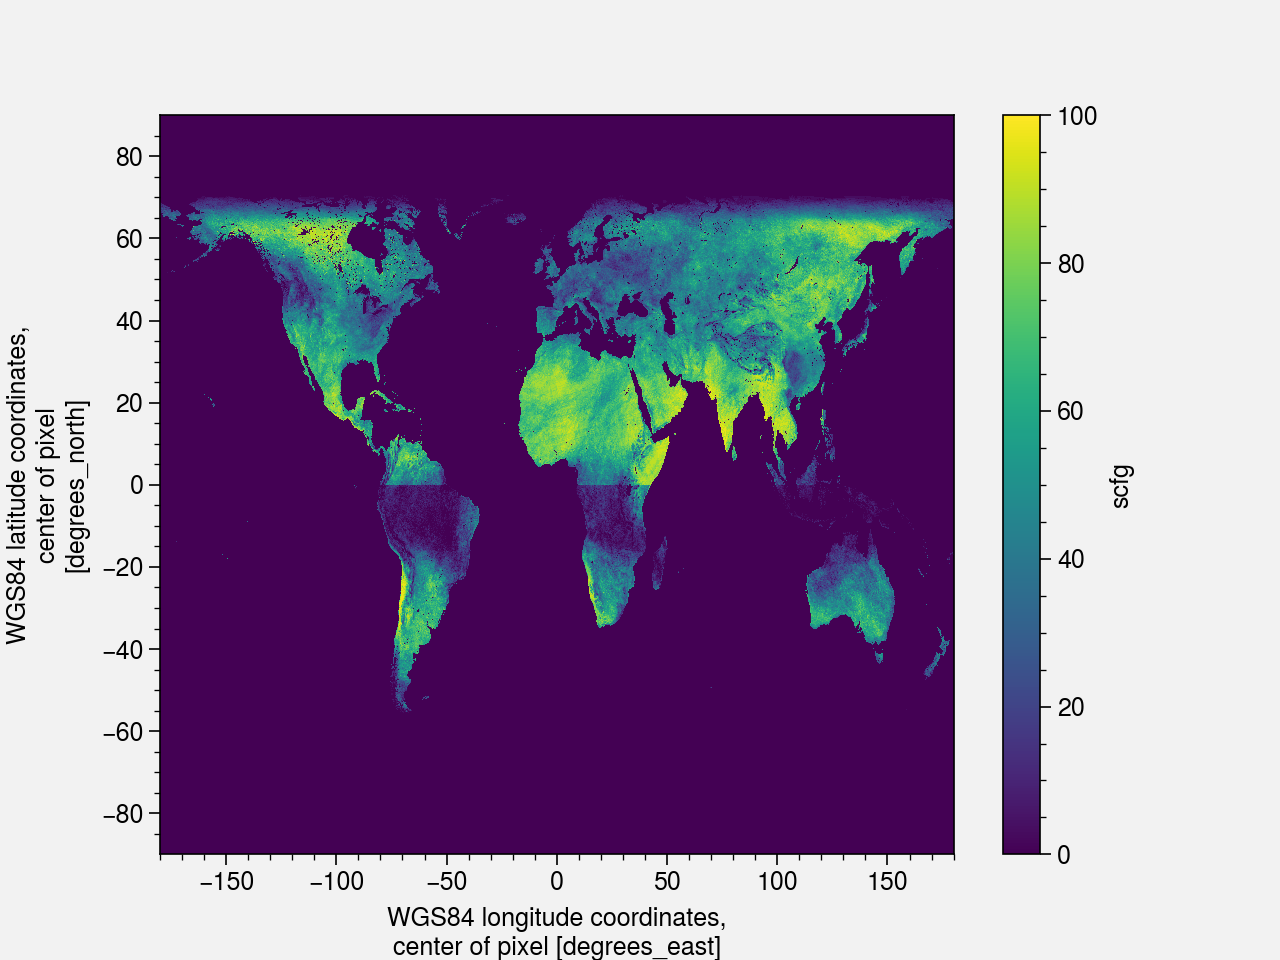

In [40]:
data_coverage.plot()

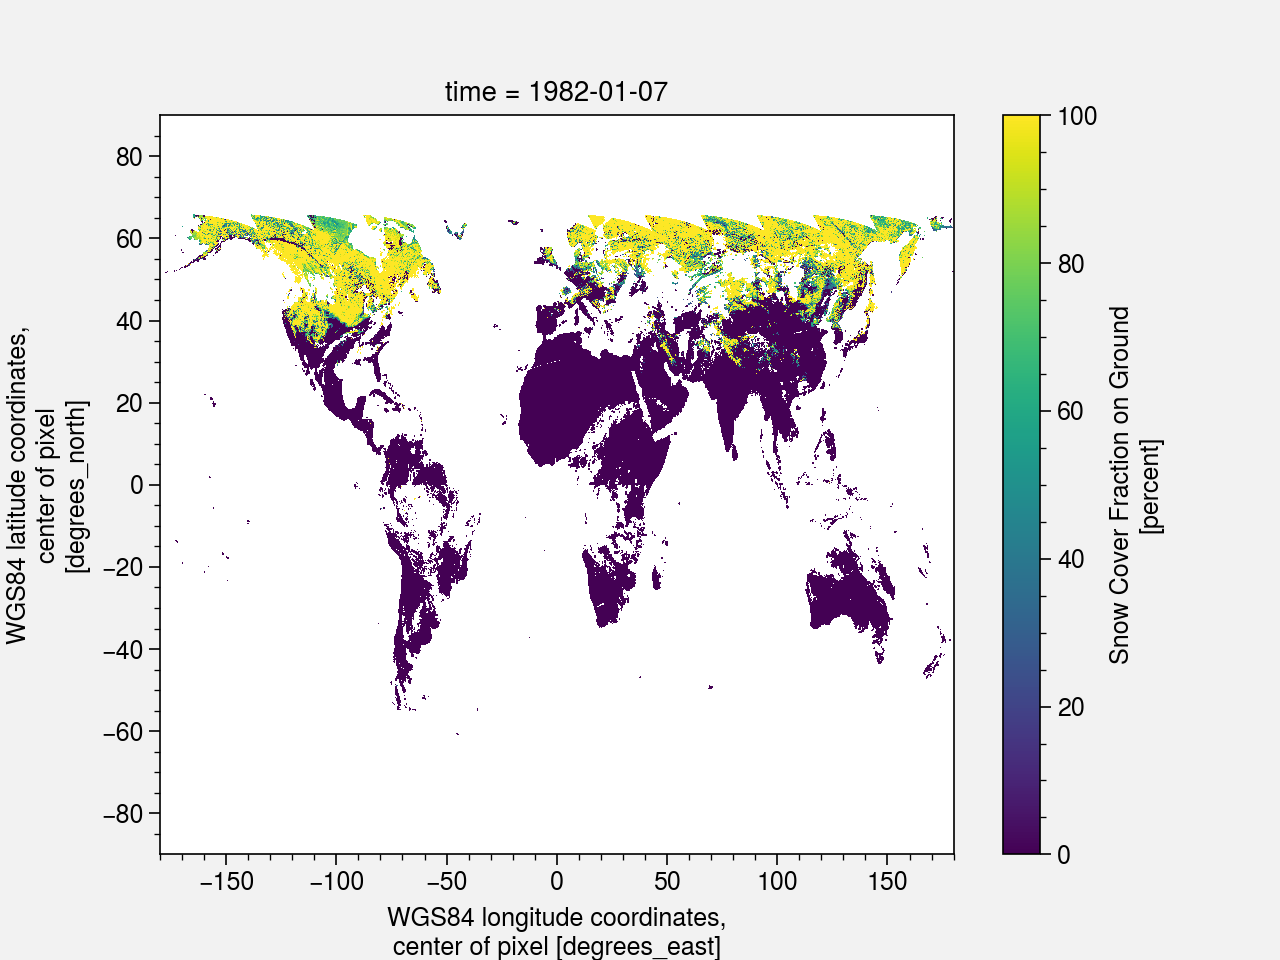

In [41]:
scf[6].plot()

## Linear temporal gapfill

In [42]:
scf

<xarray.DataArray 'scfg' (time: 30, lat: 3600, lon: 7200)>
dask.array<rechunk-merge, shape=(30, 3600, 7200), dtype=float32, chunksize=(30, 1800, 1800), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * lat      (lat) float64 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-01-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfg_unc

In [66]:
int(scf.lat.size/20)

180

In [67]:
int(scf.lon.size/20)

360

In [68]:
scf = scf.chunk({'time': -1, 'lat': 180, 'lon': 360})
scf

,Array,Chunk
Bytes,3.11 GB,7.78 MB
Shape,"(30, 3600, 7200)","(30, 180, 360)"
Count,1486 Tasks,400 Chunks
Type,float32,numpy.ndarray


In [31]:
scf_interp = scf.interpolate_na('time', method='linear', max_gap=pd.Timedelta(days=10))

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/core.py:3949: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


In [32]:
%%time
clim_interp = scf_interp.mean('time').load()

CPU times: user 2min 18s, sys: 10.5 s, total: 2min 29s
Wall time: 5min 52s


In [25]:
%%time
clim_interp = scf_interp.mean('time').load()

CPU times: user 2min 13s, sys: 9.61 s, total: 2min 22s
Wall time: 9min


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


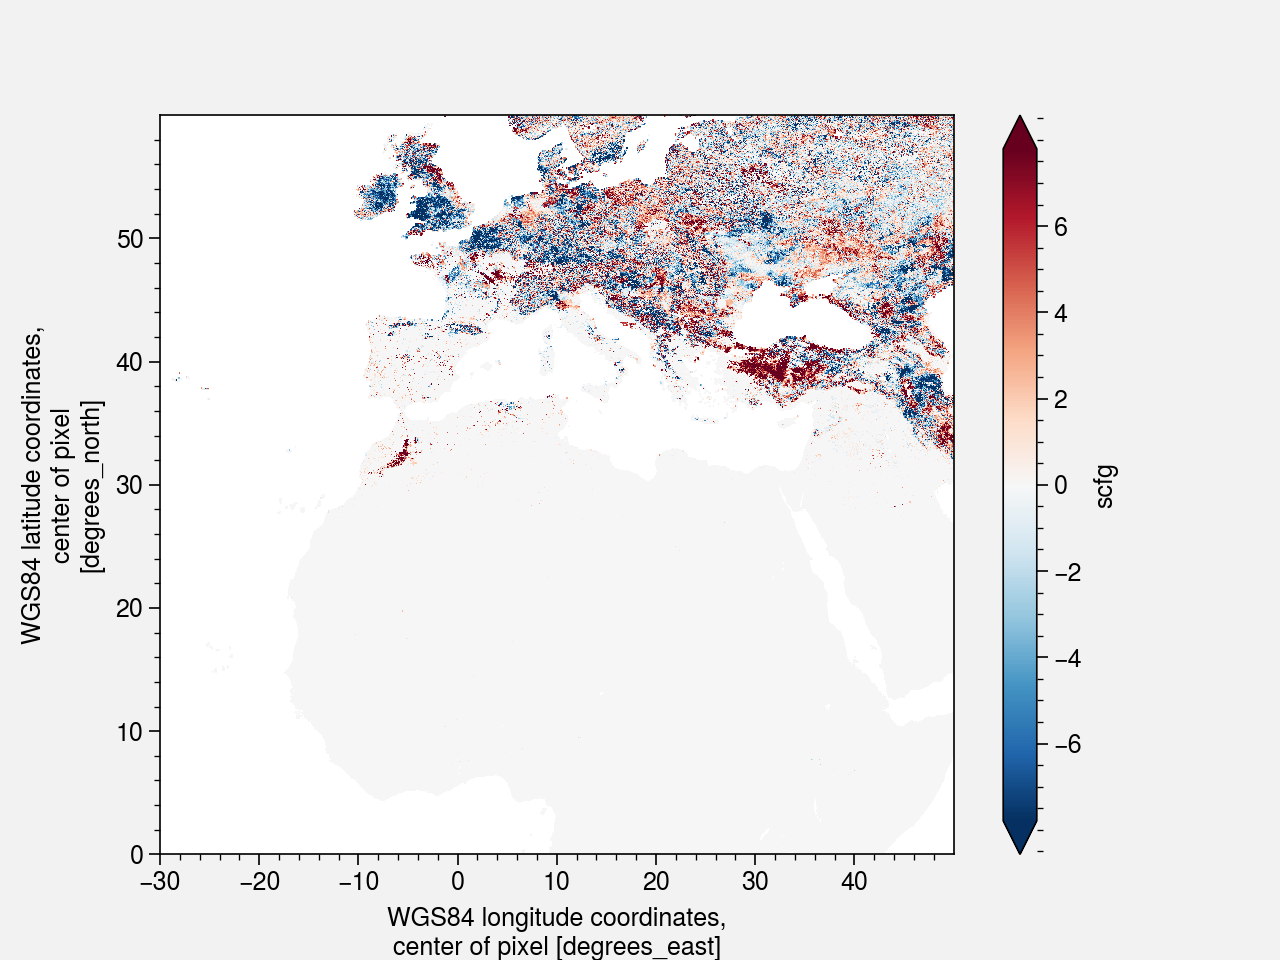

In [21]:
(scf_subset_interp.mean('time') - scf_subset.mean('time')).plot(robust=True)

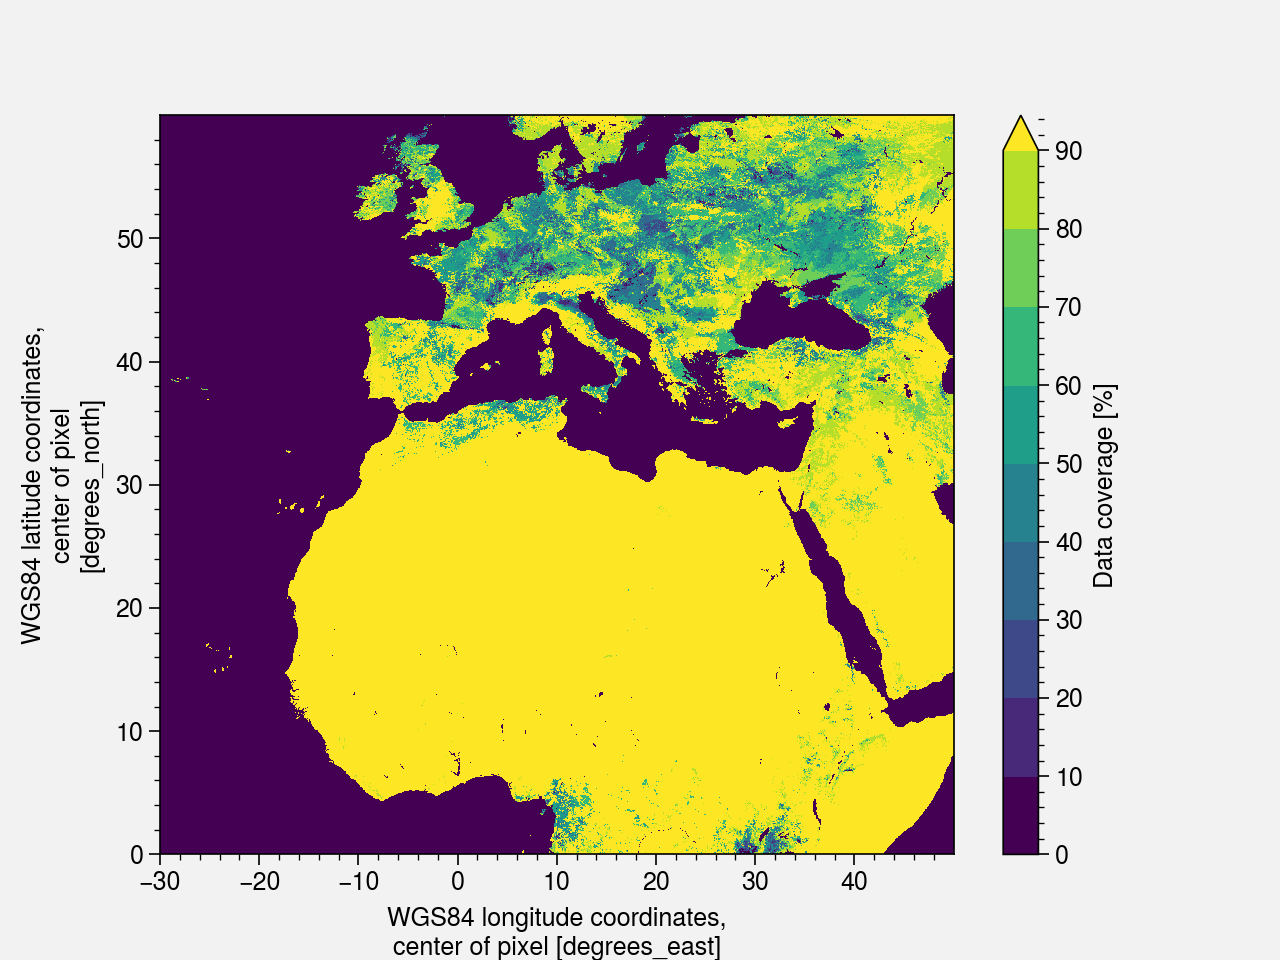

In [47]:
data_coverage_interp = ((scf_subset_interp.count('time') / scf.time.size)*100)
data_coverage_interp.name = 'Data coverage'
data_coverage_interp.attrs['units'] = '%'

data_coverage_interp.plot(levels=plot.arange(0, 90, 10), extend='max')

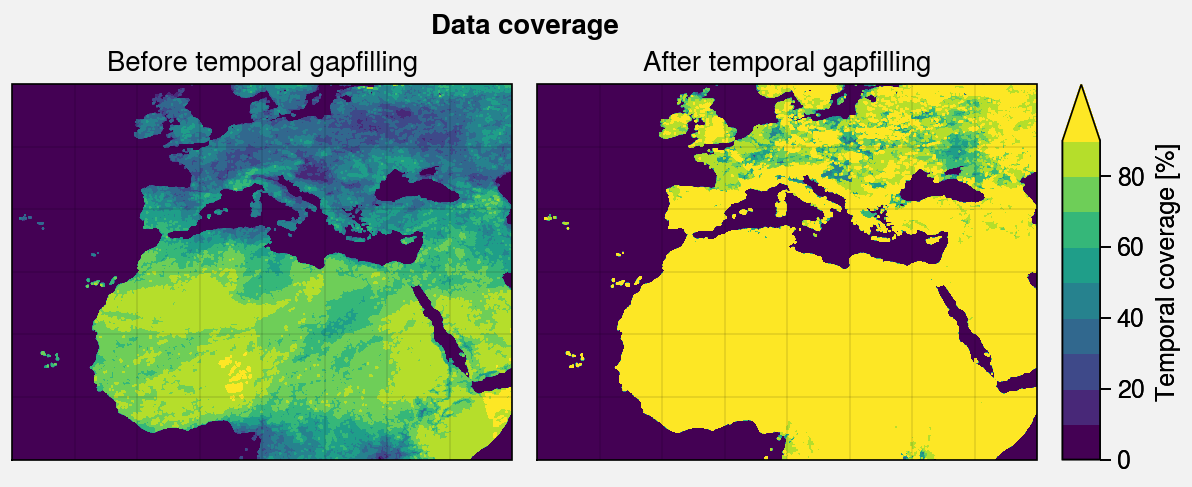

In [54]:
fig, axs = plot.subplots(ncols=2, proj='cyl')

levels = plot.arange(0, 90, 10)
extend = 'max'
cmap='viridis'

m = axs[0].contourf(data_coverage, levels=levels, extend=extend, cmap=cmap)
axs[1].contourf(data_coverage_interp, levels=levels, extend=extend, cmap=cmap)

fig.colorbar(m, label='Temporal coverage [%]')

for title, ax in zip(['Before temporal gapfilling', 'After temporal gapfilling'], axs):
    ax.format(title=title)
    
axs.format(
    suptitle='Data coverage',
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop)
)

## Monthly mean

In [23]:
scf_monsubset_interp = scf_subset_interp.groupby('time.month').mean('time')

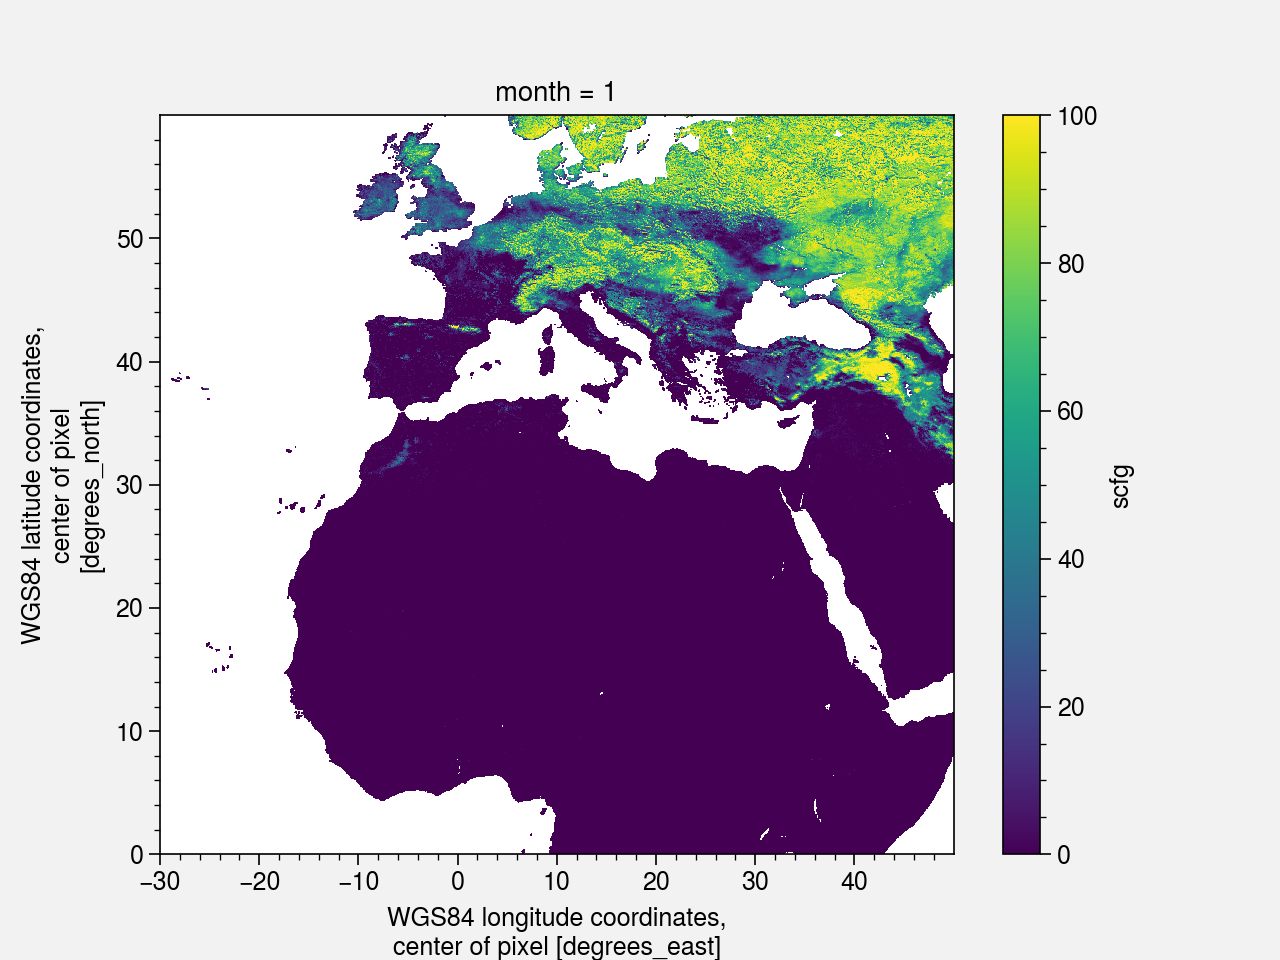

In [25]:
scf_monsubset_interp[0].plot()

## Spatial aggregation to 25km

In [56]:
scf_monsubset_interp.lat[1] - scf_monsubset_interp.lat[0]

<xarray.DataArray 'lat' ()>
array(0.05)

In [58]:
0.25/0.05

5.0

In [61]:
scf_monsubset_interp_coarsen = scf_monsubset_interp.coarsen(lat=5, lon=5).mean()

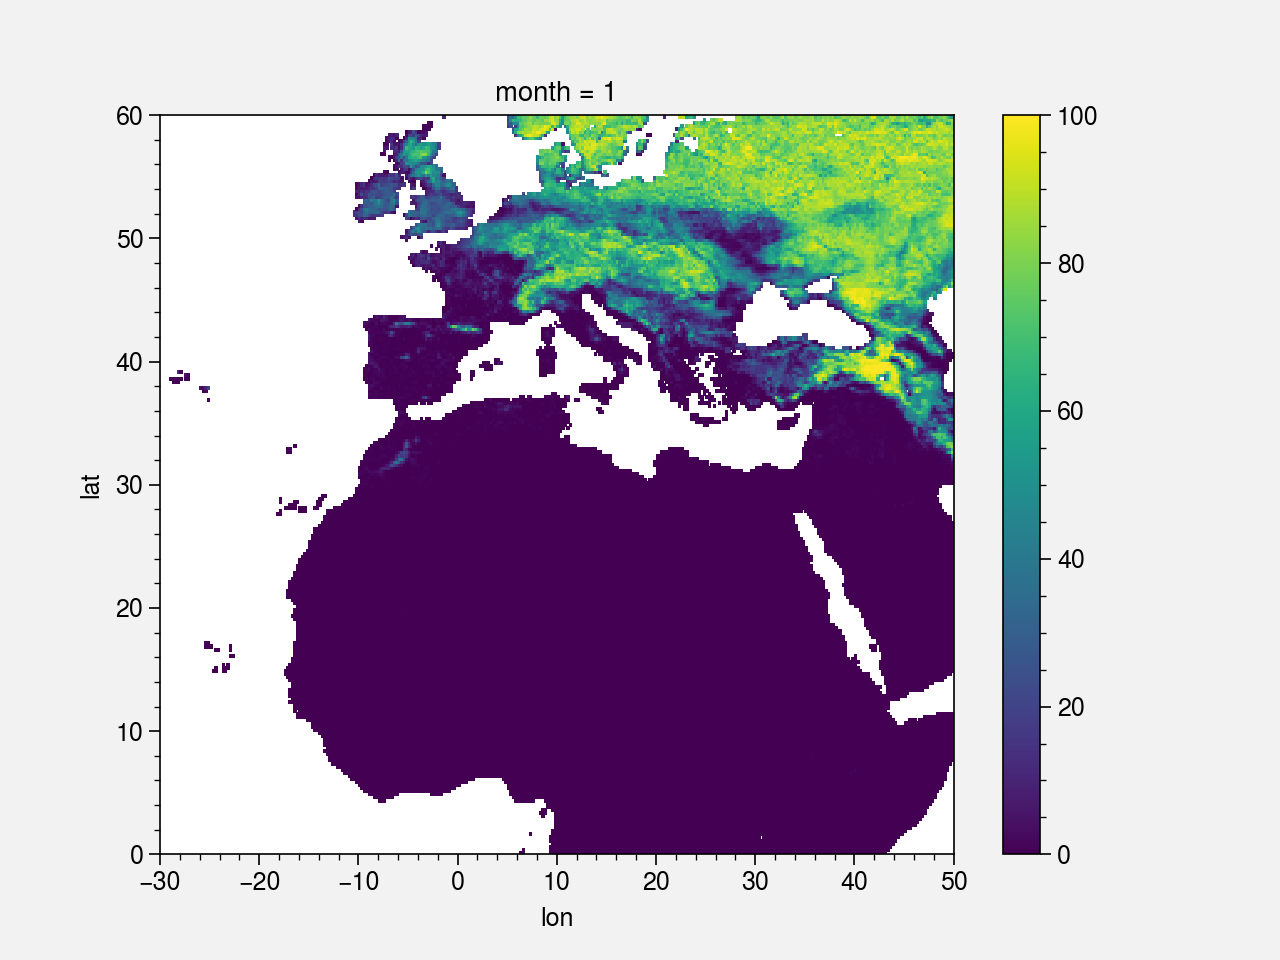

In [64]:
scf_monsubset_interp_coarsen[0].plot()